In [1]:
# import
# some imports...
import pandas as pd
from ipywidgets import widgets, interact
import pingouin as pg
import sys
import random
import glob
import seaborn as sns
import math
import time
from tqdm.notebook import tqdm
import pickle
import scipy.io
from scipy import stats, special
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload

# plot specs
sns.set_style("whitegrid")
colors_prof = ['#00B0AE','#FB1755','#DD8911']

#import mne
#!{sys.executable} -m pip install pingouin
sys.path.append('./scripts/')
from resProcessFunc import *
from feat_compute_2 import *
from var_f import *
# shap
import shap
# xgboost
from xgboost import XGBRegressor, plot_importance
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error

# %% Paths
resPath = "data/raw_results/"
seqPath = "data/bws_seq/"
formatPath = "data/formatted_results/"
scorePath = "data/scores/"

translate_d1 = {'brightness':'brillant', 'warmth':'chaud', 'roundness':'rond','roughness':'rugueux'}
translate_d2 = {'brillant':'brightness', 'chaud':'warmth', 'rond':'roundness','rugueux':'roughness'}

# pandas and pandas options
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 40)

/Users/victorrosi/miniconda3/lib/python3.8/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.0, the latest is 0.5.1.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


# Loading / Formating data

Script that format all raw data in a dataframe for analysis <br>
<br>
CN = Conductors <br>
SE = Sound Engineering <br>
NE = Non-experts

In [3]:
#  !!! change 
print("Click and run if need to reload everything")
files = [f for f in listdir(resPath) if isfile(join(resPath, f))]
if ".DS_Store" in files:
    files.remove(".DS_Store")
    
res_df = pd.DataFrame()
for file in tqdm(files, desc ="Formatting results : "): 
        resFile = resPath+file
        tmp_df = formatData(resFile, seqPath, formatPath, save=False)
        res_df = pd.concat([res_df, tmp_df], ignore_index=True)

Click and run if need to reload everything


Formatting results :   0%|          | 0/96 [00:00<?, ?it/s]

# Mean decision time

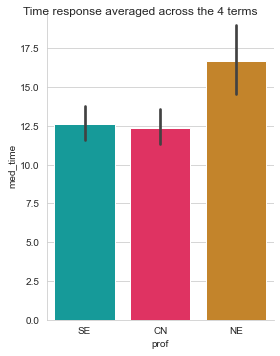

In [4]:
# plot time infos
df_analysis = res_df.groupby(["ID", "term","prof"]).mean().reset_index()

from  matplotlib.backends.backend_pdf import PdfPages
with PdfPages('figure/time.pdf') as pdf_pages:
    time = sns.catplot(x="prof", y="med_time", order=["SE","CN","NE"], aspect=0.8, kind="bar", data=df_analysis, palette=colors_prof)
    time.fig.suptitle("Time response averaged across the 4 terms")
    pdf_pages.savefig(time.fig, bbox_inches='tight')


# Consistency analysis

## Intra-participant consistency (Test-Retest index) 

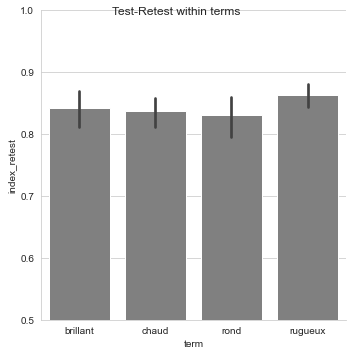

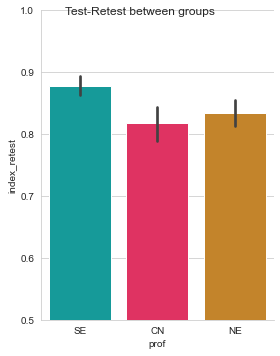

In [5]:
# ALL
#sns.set_palette(sns.color_palette(colors))
df_analysis = res_df.groupby(["ID", "term", "prof"]).mean().reset_index()
from  matplotlib.backends.backend_pdf import PdfPages
with PdfPages('figure/retest.pdf') as pdf_pages:
    retest1 = sns.catplot(x="term", y="index_retest",  order=["brillant","chaud","rond","rugueux"], data=df_analysis, kind="bar", color='grey', aspect=1)
    retest1.fig.suptitle("Test-Retest within terms")
    retest1.set(ylim=(0.5, 1))
    pdf_pages.savefig(retest1.fig, bbox_inches='tight')  
with PdfPages('figure/retest_prof.pdf') as pdf_pages:
    retest2 = sns.catplot(x="prof", y="index_retest", data=df_analysis, order=["SE","CN","NE"], kind="bar", palette=colors_prof, aspect=0.8)
    retest2.fig.suptitle("Test-Retest between groups")
    retest2.set(ylim=(0.5, 1))
    pdf_pages.savefig(retest2.fig, bbox_inches='tight')

In [6]:
df_analysis.groupby('prof').mean()

,trialNo,mean_time,med_time,index_retest,index_retest2
prof,,,,,
CN,72.0,13.5625,12.37500,0.817909,0.680288
NE,72.0,18.2500,16.71875,0.833534,0.689904
SE,72.0,14.0000,12.62500,0.878606,0.768029


In [7]:
import itertools
profs = ["SE","CN","NE"]
terms = ["brillant","chaud","rond","rugueux"]
all_profs = [i for i in itertools.combinations(profs,2)]
all_terms = [i for i in itertools.combinations(terms,2)]
pval = []

#NONPARAMETRIC ANOVA FOR BETWEEN AND WITHIN 
print("NON PARAMETRIC ANALYSIS")
print("Main effect of group and term (see 'p-unc')")
print("------------------------------------------")
print(pg.kruskal(data=df_analysis, dv='index_retest', between='prof')) #between 
print("------------------------------------------")
print(pg.kruskal(data=df_analysis, dv='index_retest', between='term')) #between 
print(pg.friedman(data=df_analysis, dv='index_retest', within='term', subject="ID")) #within
print("------------------------------------------")
for p in all_profs:
    data = df_analysis
    var = "prof"
    vd = "index_retest"
    print(p[0],p[1])
    data1 = data[vd].loc[data[var] == str(p[0])]
    data2 = data[vd].loc[data[var] == str(p[1])]
    test = pg.mwu(data1,data2)
    pval.append(float(test['p-val'].round(4)))
    print(test) 
    print("corrected p-value = "+str(float(test['p-val'].round(4))*len(all_profs)))

NON PARAMETRIC ANALYSIS
Main effect of group and term (see 'p-unc')
------------------------------------------
        Source  ddof1          H     p-unc
Kruskal   prof      2  12.636253  0.001803
------------------------------------------
        Source  ddof1         H     p-unc
Kruskal   term      3  2.191533  0.533618
         Source         W  ddof1         Q     p-unc
Friedman   term  0.050113      3  3.608108  0.307009
------------------------------------------
SE CN
     U-val alternative     p-val       RBC      CLES
MWU  751.5   two-sided  0.001255 -0.467773  0.733887
corrected p-value = 0.0039
SE NE
     U-val alternative     p-val      RBC      CLES
MWU  720.0   two-sided  0.005043 -0.40625  0.703125
corrected p-value = 0.015
CN NE
     U-val alternative    p-val       RBC      CLES
MWU  456.0   two-sided  0.45414  0.109375  0.445312
corrected p-value = 1.3623


## Inter-participant consistency (mean compliance)

In [8]:
# few essential variables (run everytime)
print("Click and run to load scoring specs")
methods = ["Value","Elo","RW","Best","Worst","Unchosen","BestWorst","ABW","David","ValueLogit","RWLogit","BestWorstLogit"] # "EloLogit",
methodChoice = methods[0]
terms = ["brillant","chaud","rond","rugueux"]
profs = ["SE","CN","NE"]

Click and run to load scoring specs


### 3 set of scores computed for each group of N=8 participants
Compliance score for each participant is computed from scores obtain for they group (e.g. Compliance of SE01 is computed with Sound engineers scores)

In [9]:
# Load all scores data sep
profs=["SE","CN","NE"]
terms = ["brillant","chaud","rond","rugueux"]
df_analysis = pd.DataFrame()
compliance_df = pd.DataFrame(columns=["ID","compliance","term","prof"])
for i, prof in enumerate(profs):
    comp_list = []
    terms = ["brillant","chaud","rond","rugueux"]
    term1_df = pd.read_csv(scorePath+"scores_"+terms[0]+"_"+prof+".csv")[["sounds", methodChoice]]
    term1_df.columns = ['sounds', terms[0]]
    term2_df = pd.read_csv(scorePath+"scores_"+terms[1]+"_"+prof+".csv")[["sounds", methodChoice]]
    term2_df.columns = ['sounds', terms[1]]
    term3_df = pd.read_csv(scorePath+"scores_"+terms[2]+"_"+prof+".csv")[["sounds", methodChoice]]
    term3_df.columns = ['sounds', terms[2]]
    term4_df = pd.read_csv(scorePath+"scores_"+terms[3]+"_"+prof+".csv")[["sounds", methodChoice]]
    term4_df.columns = ['sounds', terms[3]]
    tmp_all_df = term1_df.merge(term2_df, on="sounds")
    tmp_all_df = tmp_all_df.merge(term3_df, on="sounds")
    tmp_all_df = tmp_all_df.merge(term4_df, on="sounds")
    for i, term in enumerate(terms):
        tmp_df = flagNonCompliance(term, [prof], formatPath, tmp_all_df[["sounds", term]], methodChoice)
        comp_list.append(tmp_df)
        comp_tmp_df = pd.concat(comp_list)
        comp_tmp_df = comp_tmp_df.sort_values(by=['prof','ID'])
    compliance_df = pd.concat([compliance_df, comp_tmp_df]) 

#### Non parametric

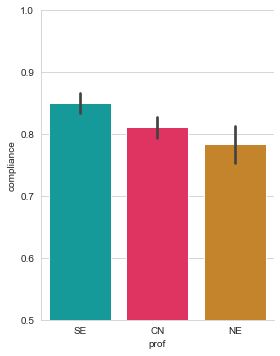

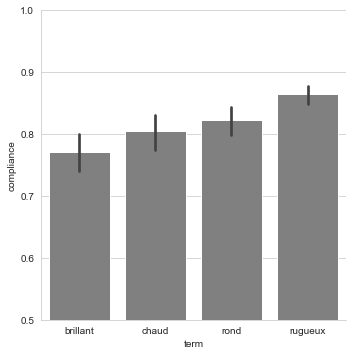

In [10]:
from  matplotlib.backends.backend_pdf import PdfPages
with PdfPages('figure/compliance_prof.pdf') as pdf_pages:
    colors = ["#368563","#BF1857",'#B7C3BE']
    sns.set_palette(sns.color_palette(colors))
    c = sns.catplot(x="prof", y="compliance", order=["SE", "CN", "NE"], data=compliance_df, kind="bar", palette=colors_prof, aspect=0.8) 
    #c.fig.suptitle('Compliance of populations with scores computed with '+methodChoice+" scoring ")
    c.set(ylim=(0.5, 1))
    pdf_pages.savefig(c.fig, bbox_inches='tight') 

with PdfPages('figure/compliance_term.pdf') as pdf_pages:
    colors = ["#368563","#BF1857",'#B7C3BE']
    sns.set_palette(sns.color_palette(colors))
    c = sns.catplot(x="term", y="compliance", data=compliance_df, kind="bar", color='grey', aspect=1) 
    #c.fig.suptitle('Compliance of populations with scores computed with '+methodChoice+" scoring ")
    c.set(ylim=(0.5, 1))
    pdf_pages.savefig(c.fig, bbox_inches='tight') 
    
# NONPARAMETRIC ANOVA FOR BETWEEN AND WITHIN 
#print(pg.mixed_anova(data=compliance_df, dv="compliance", between="prof", within="term", subject="ID").round(3))

In [11]:
print("NON PARAMETRIC ANALYSIS")
print("Main effect of group and term (see 'p-unc')")
print("----------------between-groups------------------")
print(pg.kruskal(data=compliance_df, dv='compliance', between='prof')) #between 
print("---------------between-concepts-----------------")
print(pg.kruskal(data=compliance_df, dv='compliance', between='term')) #between 
print(pg.friedman(data=compliance_df, dv='compliance', within='term', subject="ID")) #within
print("-------------pairwise-mann-whitney--------------")

import itertools
profs = ["SE","CN","NE"]
terms = ["brillant","chaud","rond","rugueux"]
all_profs = [i for i in itertools.combinations(profs,2)]
all_terms = [i for i in itertools.combinations(terms,2)]
pval_term= []
pval_prof= []
pval= []
for p in all_profs:
    data = compliance_df
    var = "prof"
    vd= "compliance"
    print(p[0],p[1])
    data1 = data[vd].loc[data[var] == str(p[0])]
    data2 = data[vd].loc[data[var] == str(p[1])]
    test = pg.mwu(data1,data2)
    pval.append(float(test['p-val'].round(4)))
    print(test) 
    print("corrected p-value = "+str(float(test['p-val'].round(4))*len(all_profs)))
for p in all_terms:
    data = compliance_df
    var = "term"
    vd = "compliance"
    print(p[0],p[1])
    data1 = data[vd].loc[data[var] == str(p[0])]
    data2 = data[vd].loc[data[var] == str(p[1])]
    test = pg.mwu(data1,data2)
    pval.append(float(test['p-val'].round(4)))
    print(test) 
    print("corrected p-value = "+str(float(test['p-val'].round(4))*len(all_terms)))

NON PARAMETRIC ANALYSIS
Main effect of group and term (see 'p-unc')
----------------between-groups------------------
        Source  ddof1          H     p-unc
Kruskal   prof      2  15.174027  0.000507
---------------between-concepts-----------------
        Source  ddof1          H     p-unc
Kruskal   term      3  27.292615  0.000005
         Source         W  ddof1          Q     p-unc
Friedman   term  0.413354      3  29.761506  0.000002
-------------pairwise-mann-whitney--------------
SE CN
     U-val alternative     p-val       RBC      CLES
MWU  748.0   two-sided  0.001564 -0.460938  0.730469
corrected p-value = 0.0048000000000000004
SE NE
     U-val alternative     p-val       RBC      CLES
MWU  772.0   two-sided  0.000492 -0.507812  0.753906
corrected p-value = 0.0015
CN NE
     U-val alternative    p-val       RBC      CLES
MWU  562.0   two-sided  0.50621 -0.097656  0.548828
corrected p-value = 1.5186
brillant chaud
     U-val alternative     p-val       RBC      CLES
MWU  20

# Analysis on BWS scores - between attributs

"!" Don't forget to set the profession you want to evaluate. 'EX' is for the grouped expert population <br>
Choose the profil for analysis ('SE', 'CN', 'NE, 'EX') (press 'Enter')

## Correlations between concepts

Load data you want to analyse, here for NE


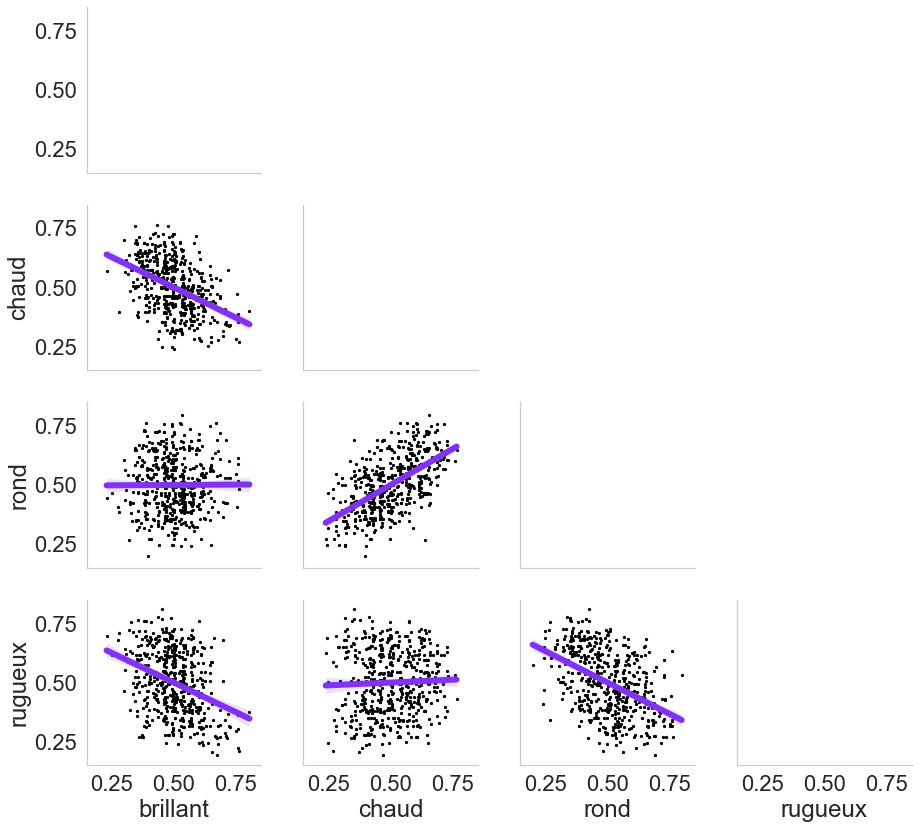

In [59]:
# Load all scores data
terms = ["brillant","chaud","rond","rugueux"]
profs = ["SE","CN","NE"]
import itertools
pairs_object = itertools.combinations(terms, 2)
pairs = list(pairs_object)
show = False
prof = "NE"
print("Load data you want to analyse, here for "+prof)
term1_df = pd.read_csv(scorePath+"scores_"+terms[0]+"_"+prof+".csv")[["sounds", methodChoice]]
term1_df.columns = ['sounds', terms[0]]
term2_df = pd.read_csv(scorePath+"scores_"+terms[1]+"_"+prof+".csv")[["sounds", methodChoice]]
term2_df.columns = ['sounds', terms[1]]
term3_df = pd.read_csv(scorePath+"scores_"+terms[2]+"_"+prof+".csv")[["sounds", methodChoice]]
term3_df.columns = ['sounds', terms[2]]
term4_df = pd.read_csv(scorePath+"scores_"+terms[3]+"_"+prof+".csv")[["sounds", methodChoice]]
term4_df.columns = ['sounds', terms[3]]
#
all_data_df = term1_df.merge(term2_df, on="sounds")
all_data_df = all_data_df.merge(term3_df, on="sounds")
all_data_df = all_data_df.merge(term4_df, on="sounds")

for i, pair in enumerate(pairs):   
    pears = stats.pearsonr(all_data_df[pair[0]].values, all_data_df[pair[1]].values)
    spear  = stats.spearmanr(all_data_df[pair[0]].values, all_data_df[pair[1]].values)
    if show == True:
        print('----------------------')
        print(translate_d2[pair[0]], translate_d2[pair[1]]) 
        #print(pears)
        print("Pearson's r : "+str(pears[0].round(2))+" p-value : "+str(pears[1].round(4)))

from  matplotlib.backends.backend_pdf import PdfPages
with PdfPages('figure/corrplot_'+prof+'.pdf') as pdf_pages:
    sns.set(font_scale=2, style="whitegrid")
    sns.set_style("whitegrid", {'axes.grid' : False})
    g = sns.PairGrid(all_data_df, corner = True, aspect = 1.1, height=3)
    g.map_lower(sns.regplot, scatter_kws={'alpha':1, 's':5, "color": 'black'}, line_kws={"lw":6, "color": '#8132F3'})
    #g.map_diag(sns.histplot, kde=True)
    g.set(ylim=(0.15,0.85))
    g.set(xlim=(0.15,0.85))
    pdf_pages.savefig(g.fig, bbox_inches='tight')

# Acoustic analysis

## Loading feature

In [14]:
# acoustic features
feat_df = pd.read_csv("./data/features_acoustic.csv")
# meta features
meta_df = pd.read_csv("./data/features_meta.csv")
feat_plot_df = pd.merge(feat_df, meta_df, on="sounds")
meta_df = pd.get_dummies(meta_df, columns=['instrument','technique']) # one hot meta data
#impact = ["guitare","harpa","ME","HH","HO","GA","pizz","pizz_lv","pizz_bartok","ES_Ha_sp-0", "ES_So_sp-0", "ES_A-Ha", "ES_A-So"]
#meta_df["impact"] = meta_df["sounds"].apply(lambda x: int(any(substring in x for substring in impact)))
# target (perceptual ratings)
target_df = pd.read_csv("./data/target_data.csv")
feat_plot_df = pd.merge(feat_plot_df, target_df, on="sounds")

## Multicollinearity check

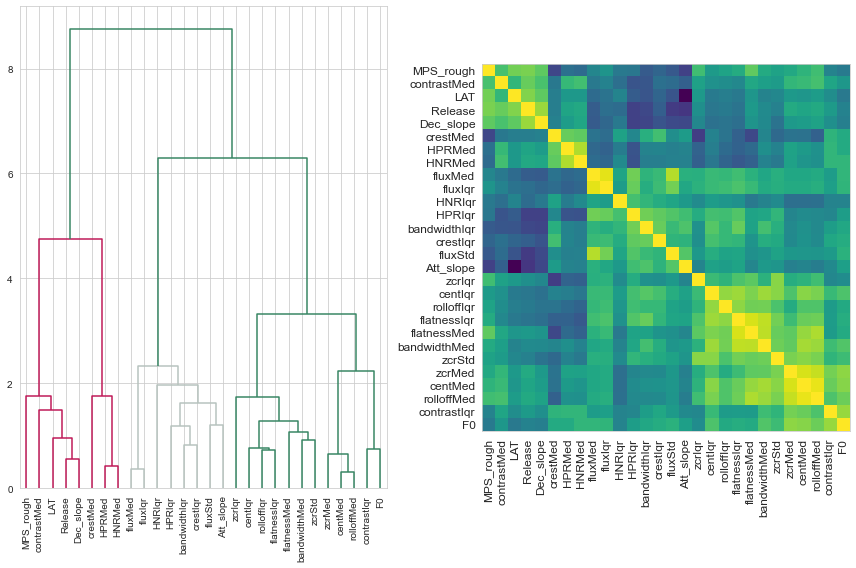

In [15]:
X, y = dataset_build("brillant","SE",feat_df, meta_df, target_df, False, True)
checkMultColl(X, True)

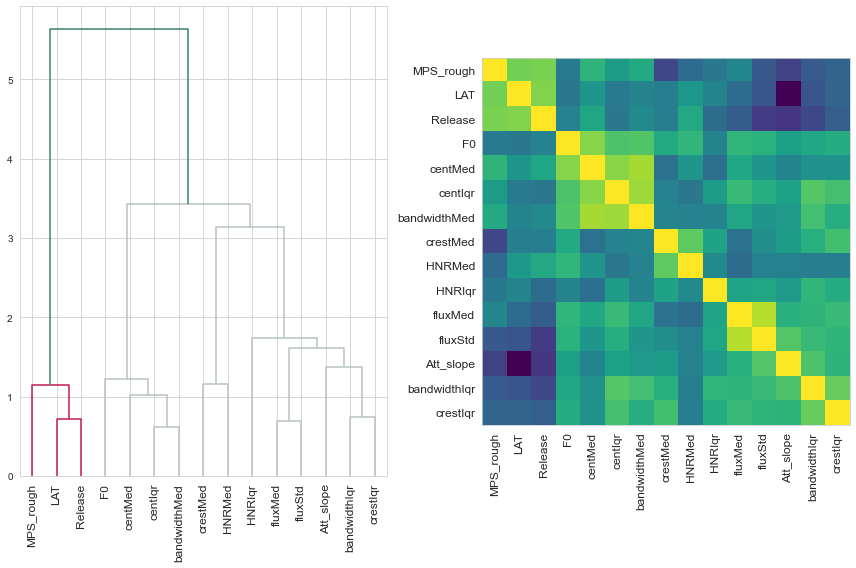

In [16]:
X, y = dataset_build("brillant","SE",feat_df, meta_df, target_df, False, True)
feat_drop = ["zcrMed",
             "HPRMed", # a supprimer
             "HPRIqr", # a supprimer
             "zcrIqr",
             "fluxIqr",
             "contrastMed",
             "flatnessMed",
             "flatnessIqr",
             "contrastIqr",
             "Dec_slope",
             "rolloffMed",
             "rolloffIqr",
             "zcrStd", # a supprimer
            ]
X = X.drop(feat_drop, axis=1)
checkMultColl(X, True)

## Cross-validated Regression task

ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.


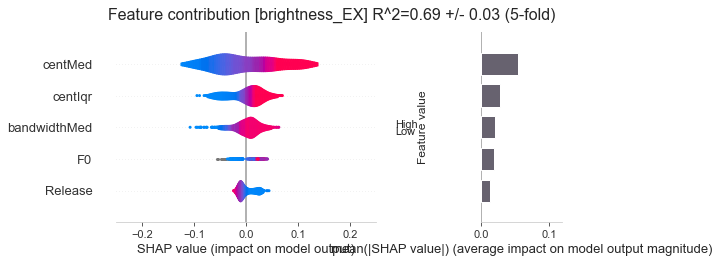

In [17]:
att="brightness" # attribute (brightness warmth roundness, roughness)
profil="NE" # participant group (SE: sound engineers, CN: Conductors, NE: Non-experts)
num_feat = 5 # Number of feature to visualise

# prepping input(X)-output(y) dataset
X, y = dataset_build(translate_d1[att],profil,feat_df, meta_df, target_df, True, False)
X = X.drop(feat_drop, axis=1)
# replace multiphonics' F0 numeric values to nans.
X.loc[X.F0 == -100, 'F0'] = np.nan 
# normalizing output
y=((y-y.min())/(y.max()-y.min()))
# number of splits for cross-validation 
cv = 5 
kf = KFold(n_splits=cv,shuffle=True)

X_train = pd.DataFrame()
X_test = pd.DataFrame()
y_train = pd.DataFrame()
y_test = pd.DataFrame()
list_shap_values = list()
list_test_sets = list()
R2_list = list()

for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index,:], X.iloc[test_index,:]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    #model specs
    model = XGBRegressor(n_estimators=500, max_depth=7, eta=0.01, subsample=0.4, colsample_bytree=0.6, min_child_weight=0.4).fit(X_train, y_train)   
    # append accuracy scores
    R2_list.append(r2_score(y_test, model.predict(X_test))) 
    #explaining model
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_test)
    #for each iteration we save the test_set index and the shap_values
    list_shap_values.append(shap_values)
    list_test_sets.append(test_index)
    
#combining results from all iterations
test_set = list_test_sets[0]
shap_values = np.array(list_shap_values[0])
for i in range(1,len(list_test_sets)):
    test_set = np.concatenate((test_set,list_test_sets[i]),axis=0)
    shap_values = np.concatenate((shap_values,np.array(list_shap_values[i])),axis=0)
#bringing back variable names    
X_test = X.iloc[test_set]

#creating explanation  (violin) plot for the whole experiment, the first dimension from shap_values indicate the class we are predicting 
fig, (ax1, ax2) = plt.subplots(1, 2, gridspec_kw={'width_ratios': [3, 0.75]})
plt.subplot(1,2,1)
plt.xlim(-0.25, 0.25)
shap.summary_plot(shap_values, X_test, plot_type="violin", show=False, max_display=num_feat)
ax1.grid(False)
plt.subplot(1,2,2)
plt.xlim(0, 0.12)
shap.summary_plot(shap_values, X_test, feature_names=X_test.columns, show=False, max_display=num_feat,color="#67626F", plot_type='bar')
# Get the current figure and axes objects.
ax2.grid(False)
ax2.get_yaxis().set_visible(False)
ax2.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    left=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelleft=False) # labels along the bottom edge are off
fig.suptitle('Feature contribution ['+att+'_'+profil+'] R^2='+str(np.round(np.mean(R2_list), 2))+" +/- "+str(np.round(np.std(R2_list),2))+' ('+str(cv)+'-fold)', fontsize = 16)
fig.savefig('figure/summary_plot_'+att+'_'+profil+'_xgboost_.pdf', bbox_inches='tight')

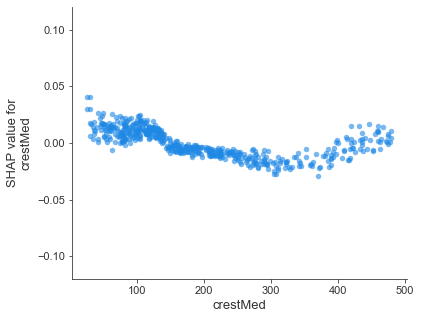

In [313]:
### create a dependence plot to show the effect of a single feature across the whole dataset
feat1 = "crestMed" # x-axis
feat2 = None #HUE

shap.dependence_plot(feat1, shap_values, X_test, 
                     interaction_index=feat2,
                     alpha=0.6,
                     dot_size=30,
                     show=False)
plt.grid(False)
plt.ylim(-0.12,0.12)
plt.savefig('figure/depend_'+profil+'_'+att+'_'+str(feat1)+'_'+str(feat2)+'.pdf', bbox_inches='tight') 
#plt.xlim(35,75)

## Compliance vs. Accuracy

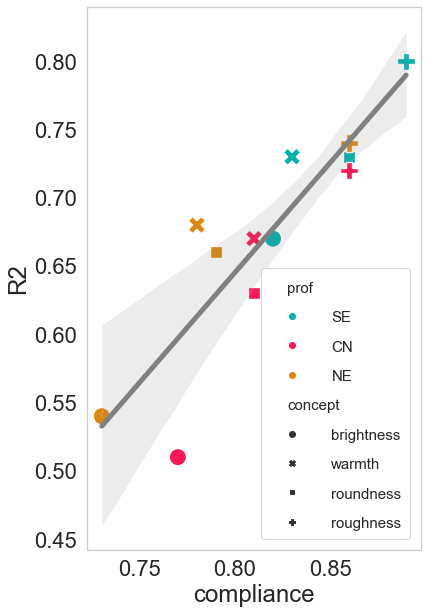

In [309]:
comp_R2_df = pd.DataFrame()
comp_R2_df["compliance"] = [0.82, 0.83, 0.86, 0.89, 0.77, 0.81, 0.81, 0.86, 0.73, 0.78, 0.79, 0.86]
comp_R2_df["R2"] = [0.67, 0.73, 0.73, 0.8, 0.51, 0.67, 0.63, 0.72, 0.54, 0.68, 0.66, 0.74]
comp_R2_df["prof"] = ["SE", "SE", "SE", "SE", "CN", "CN", "CN", "CN", "NE", "NE", "NE", "NE"]
comp_R2_df["color"] = ['#00B0AE']*4 + ['#FB1755']*4 + ['#DD8911']*4 
comp_R2_df["concept"] = ["brightness", "warmth", "roundness", "roughness", "brightness", "warmth", "roundness", "roughness", "brightness", "warmth", "roundness", "roughness"]

fig = plt.figure(figsize=(6,10))
#right_side = plt.spines["right"]
plt.grid(False)
g = sns.scatterplot(x="compliance", y="R2", hue="prof", palette=['#00B0AE','#FB1755','#DD8911'], style="concept", s=300, data=comp_R2_df)
plt.grid(False)
h = sns.regplot(x="compliance", y="R2", scatter=False, color="grey", line_kws={'lw':5}, data=comp_R2_df)
plt.setp(g.get_legend().get_texts(), fontsize='15')
plt.show()
fig.savefig('figure/reg_comp_R2.pdf', bbox_inches='tight')

#sns.lineplot(x="compliance", y="R2", data=comp_R2_df, hue="prof")
pears  = stats.pearsonr(comp_R2_df["compliance"].values, comp_R2_df["R2"].values)

# Frequency of use (form)

(0.0, 7.0)

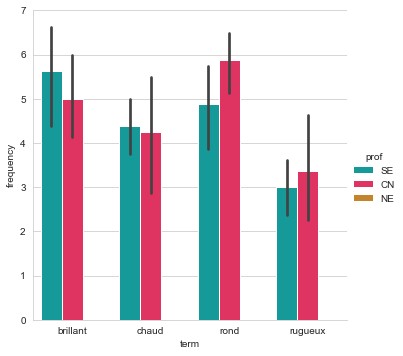

In [152]:
profs = ["SE","CN","NE"]
form_df = pd.read_csv('data/form.csv', delimiter=";")
form_df["term"] = form_df["term"].str.lower()
form_df["prof"] = form_df["ID"].str[:2]
#form_pro_df = form_df.loc[(form_df["prof"] == "SE") | (form_df["prof"] == "CN")]

c2 = sns.catplot(x="term", y="frequency", hue='prof', hue_order=profs, data=form_pro_df, kind="bar", aspect=1, palette=colors_prof)
plt.ylim([0,7])

In [290]:
print(pg.mixed_anova(data=form_pro_df, dv='frequency', between="prof", within='term', subject="ID")) #within
print(pg.pairwise_ttests(data=form_pro_df, dv="frequency", within='term', subject='ID', effsize='cohen', padjust="bonf"))

        Source         SS  DF1  DF2         MS         F     p-unc       np2  \
0         prof   0.390625    1   14   0.390625  0.103734  0.752152  0.007355   
1         term  50.796875    3   42  16.932292  9.855782  0.000048  0.413140   
2  Interaction   5.796875    3   42   1.932292  1.124729  0.349945  0.074364   

        eps  
0       NaN  
1  0.896836  
2       NaN  
  Contrast         A        B  Paired  Parametric         T   dof alternative  \
0     term  brillant    chaud    True        True  1.967478  15.0   two-sided   
1     term  brillant     rond    True        True -0.144438  15.0   two-sided   
2     term  brillant  rugueux    True        True  5.358042  15.0   two-sided   
3     term     chaud     rond    True        True -1.927343  15.0   two-sided   
4     term     chaud  rugueux    True        True  2.422719  15.0   two-sided   
5     term      rond  rugueux    True        True  5.202101  15.0   two-sided   

      p-unc    p-corr p-adjust     BF10     cohen  
0  

# Scoring - individuals (if needs to regenerate scores)

Scoring all data. Always run the "set up analysis" part. Not necessary to run it.

In [26]:
#%% SCORING - DO NOT RUN UNLESS A NEW PARTICIPANT CAME IN
methods = ["Value","Elo","RW","Best","Worst","Unchosen","BestWorst","ABW","David","ValueLogit","RWLogit","BestWorstLogit"] # "EloLogit",
methodChoice = methods[0]
profs = ["SE","CN","NE","ALL"]
terms = ["brillant","chaud","rond","rugueux"]
for prof in tqdm(profs, desc ="Scoring : "):
    for term in tqdm(terms, leave=False, desc ="scoring for "+prof+" : "):
        scoringManagement(term,prof,res_df, scorePath, methodChoice)

Scoring :   0%|          | 0/3 [00:00<?, ?it/s]

scoring for SE :   0%|          | 0/4 [00:00<?, ?it/s]

scoring for CN :   0%|          | 0/4 [00:00<?, ?it/s]

scoring for ALL :   0%|          | 0/4 [00:00<?, ?it/s]